In [2]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, ExtendedDataset, evaluate_on_test, init_weights, save_obj, load_obj, remove_nan

In [4]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0], parse_dates=True)

In [5]:
# start from 1960
full.drop(columns=['A191RL1Q225SBEA'], inplace=True)
full = full.loc["1960-01-01":]
full = remove_nan(full)
print(full.shape)

INTDSRUSM193N
ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
GS20
MCOILWTICO
TCU
TOTALSA
(709, 21)


In [6]:
class FeedforwardOneHidden(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(FeedforwardOneHidden, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # no activation at output layer
        return x
    

In [7]:
trainer = TrainHelper(percent = 0.99, manual = 5000, print_every=1000)

PATH = "./Extended One Layer/"

def train_times(times, trainer, net, criterion, optimizer, window):
    
    losses = []

    # train ten times, find best loss
    for i in range(times):
        net.apply(init_weights)
        print("Training %d time" % i)
        loss = trainer.train_window(net, criterion, optimizer, window)
        torch.save(net.state_dict(), PATH + "lag" + str(net.input_size//full.shape[1]) + "hidden" + str(net.hidden_size) + "_" + str(i) + ".pt")
        losses.append(loss)
        
    return losses

In [8]:
length = len(full)
val_start = round(length * 0.8)
test_start = round(length * 0.9)    

In [9]:
losses = {}

In [10]:
hiddens = [24]

for lags in range(1, 6):
    data = ExtendedDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

    # subtract by lags to ensure same training sets
    trainset = Subset(data, [i for i in range(val_start - 1 - lags)])
    valset = Subset(data, [i for i in range(val_start - lags, test_start - 1 - lags)])

    trainloader = DataLoader(trainset, batch_size=1, shuffle=False, sampler=SequentialSampler(trainset))
    validationloader = DataLoader(valset, batch_size=1, shuffle=False, sampler=SequentialSampler(valset))

    window = Window(trainloader, validationloader)
    
    for hidden_size in hiddens:
        print("Training new net, %d lags %d hidden" % (lags, hidden_size))

        net = FeedforwardOneHidden(lags * full.shape[1], hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        loss = train_times(10, trainer, net, criterion, optimizer, window)
        print(loss)
        losses[str(lags) + "-" + str(hidden_size)] = loss
    

Training new net, 1 lags 24 hidden
Training 0 time
[epoch: 1] train loss: 0.612, val loss: 1.027


/Users/fredchen/JupyterProjects/macro/utils.py:358: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Finished window, trained for 45 epochs, loss: 0.206
Training 1 time
[epoch: 1] train loss: 0.639, val loss: 1.140
Finished window, trained for 68 epochs, loss: 0.176
Training 2 time
[epoch: 1] train loss: 0.808, val loss: 3.296
Finished window, trained for 47 epochs, loss: 0.602
Training 3 time
[epoch: 1] train loss: 0.616, val loss: 1.041
Finished window, trained for 44 epochs, loss: 0.180
Training 4 time
[epoch: 1] train loss: 0.715, val loss: 2.860
Finished window, trained for 54 epochs, loss: 0.197
Training 5 time
[epoch: 1] train loss: 0.779, val loss: 2.425
Finished window, trained for 31 epochs, loss: 0.630
Training 6 time
[epoch: 1] train loss: 1.033, val loss: 1.936
Finished window, trained for 57 epochs, loss: 0.110
Training 7 time
[epoch: 1] train loss: 0.570, val loss: 1.093
Finished window, trained for 38 epochs, loss: 0.352
Training 8 time
[epoch: 1] train loss: 0.693, val loss: 0.902
Finished window, trained for 57 epochs, loss: 0.148
Training 9 time
[epoch: 1] train los

In [25]:
lowest = 100000000

for k, v in losses.items():
    best_loss = v[np.argmin(v)]
    if best_loss < lowest:
        lowest = best_loss
        
lowest

0.10975845688094739

In [12]:
best_loss = []
avg_loss = []

for k, v in losses.items():
    best_net_index = np.argmin(v)
    best_loss.append(v[best_net_index])
    avg_loss.append(get_average(v))


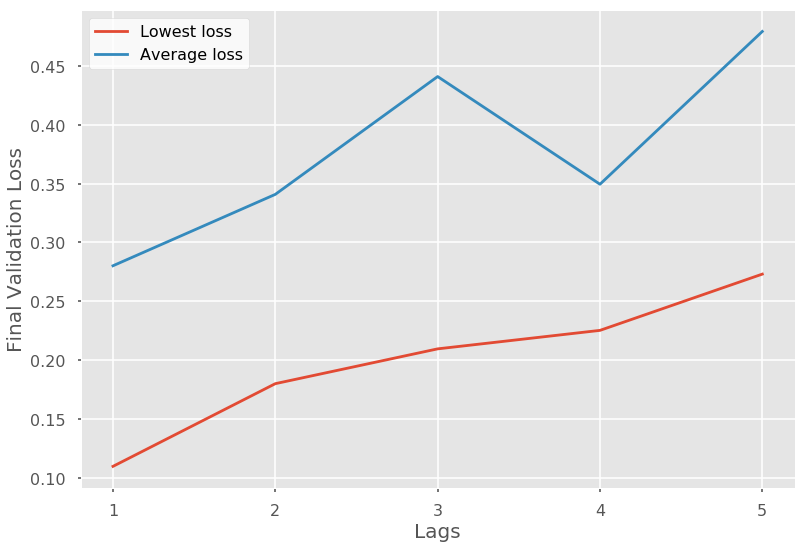

In [23]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(best_loss) + 1)], best_loss)
plt.plot([i for i in range(1, len(best_loss) + 1)], avg_loss)

plt.xticks([1, 2, 3, 4, 5])

plt.legend(("Lowest loss", "Average loss"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
plt.savefig('../Figs/lags_deep_extended.png', bbox_inches='tight')

In [11]:
save_obj(losses, "FF_Extended_One_Layer")